# CoxNet model

In [34]:
X = np.array(stacked_df[["median_InactiveDurationDay", 
                         "median_ActiveEventCountDay", 
                         "median_M6Intensity", 
                         "median_MeanCadenceDay",
                         "median_ActivityVolumeDay",
                         "median_Cadance95Day",
                         "median_TotalSleepDuration", 
                         "median_SleepEfficiency", 
                         "median_WASOCount", 
                         "median_SleepEventsNumber" , 
                         "median_ExerciseDurationDay",
                         "Age", 
                         "Sex", 
                         "HF", 
                         "IHD", 
                         "Secprev",
                         "CRT-D"]])

scaler = StandardScaler()
X = scaler.fit_transform(X)

stacked_df.loc[(stacked_df['time_first_at'] > 336) & (stacked_df['first_at_yn'] == 1), 'first_at_yn'] = 0
stacked_df.loc[(stacked_df['time_first_at'] == 336) & (stacked_df['first_at_yn'] == 1), 'time_first_at'] -= 1
y = np.array(stacked_df[['first_at_yn', 'time_first_at']])


In [35]:
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import cumulative_dynamic_auc

aux = [(e1,e2) for e1,e2 in y]
y = np.array(aux, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

model = CoxnetSurvivalAnalysis(l1_ratio=.1, alpha_min_ratio=0.1, #penalty_factor =pen_values ,
                               fit_baseline_model=True,  normalize=False)

cut_point = 336
interval = 28
va_times = np.arange(60, cut_point, interval)


from sklearn.model_selection import KFold
import numpy as np
n_splits = 3 # Adjust this number as needed
kf = KFold(n_splits=n_splits, shuffle=True, random_state=14)
mean_auc_scores = []
aucs = []
for train_index, test_index in kf.split(X):
    X_train_fold, X_val_fold = X[train_index], X[test_index]

    y_train_fold, y_val_fold = y[train_index], y[test_index]
    model.fit(X_train_fold, y_train_fold)
    
    chf_funcs = model.predict_cumulative_hazard_function(X_val_fold, return_array=False)
    risk_scores = np.row_stack([chf(va_times) for chf in chf_funcs])
    auc, mean_auc = cumulative_dynamic_auc(y_val_fold, y_val_fold, risk_scores, va_times)
    print(auc)
    mean_auc_scores.append(mean_auc)
    aucs.append(auc)

mean_auc_rounded = np.round(np.nanmean(mean_auc_scores), 3)
print('Mean AUC:', mean_auc_rounded)
std_auc = np.nanstd(mean_auc_scores)
print('Std AUC:', np.round(std_auc, 2))



[0.71170566 0.63455809 0.65795192 0.71893104 0.71893104 0.72479626
 0.6738792  0.6738792  0.6738792  0.68731808]
[0.97560976 0.97560976 0.8600823  0.775      0.75854701 0.75854701
 0.76592593 0.76592593 0.7472973  0.77334994]
[0.76708861 0.72649573 0.67269737 0.66216216 0.66216216 0.64632628
 0.67824074 0.67824074 0.67930661 0.67930661]
Mean AUC: 0.736
Std AUC: 0.05


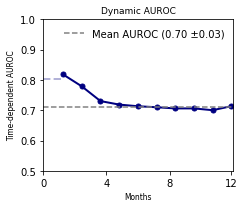

In [37]:
aucs_avg = np.mean(aucs, axis=0)
plt.figure(figsize=(3.5, 3)) 
plt.plot(va_times, aucs_avg, marker="o", markersize=5, linewidth=2, color='navy', alpha=1)
plt.xlabel("Months", labelpad=4, fontsize=7.5)
plt.ylabel("Time-dependent AUROC", labelpad=4, fontsize=7.5)
plt.axhline(y=0.80452815, xmin=0, xmax=30/315, color='navy', linestyle='--', alpha=0.3,  linewidth=2)
plt.axhline(mean_auc, linestyle="--", color='gray', label="Mean AUROC (0.70 ±0.03)", linewidth=1.5)
plt.xticks([30, 125, 220, 312], ["0", "4", "8", "12"])  # Setting the x-axis ticks
plt.legend(frameon=False)
plt.xlim(30,315)
plt.title('Dynamic AUROC', fontsize=9)
plt.ylim(0.5,1)
plt.tight_layout()
plt.show()

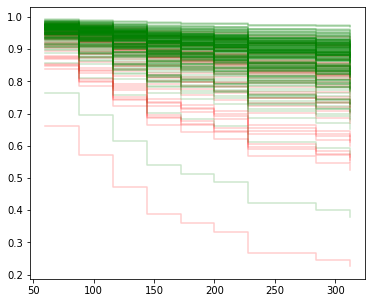

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 5))
model.fit(X, y)
pred_surv = model.predict_survival_function(X)
for i, surv_func in enumerate(pred_surv):
    if y['Status'][i] == True:
        ax.step(va_times, surv_func(va_times), where="post", color='red', alpha=0.2, label='Status: True')
    else:
        ax.step(va_times, surv_func(va_times), where="post", color='green', alpha=0.2, label='Status: False')
plt.show()

# Feature importance

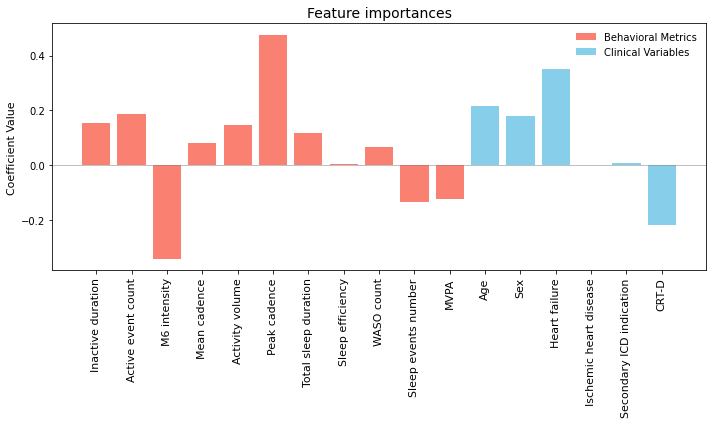

In [40]:
import pandas as pd
import numpy as np
from sksurv.linear_model import CoxnetSurvivalAnalysis
import matplotlib.pyplot as plt

features = [
    "Inactive duration",
    "Active event count",
    "M6 intensity",
    "Mean cadence",
    "Activity volume",
    "Peak cadence",
    "Total sleep duration",
    "Sleep efficiency",
    "WASO count",
    "Sleep events number",
    "MVPA",
    "Age",
    "Sex",
    "Heart failure",
    "Ischemic heart disease",
    "Secondary ICD indication",
    "CRT-D"
]

model = CoxnetSurvivalAnalysis(l1_ratio=1, alpha_min_ratio=0.01, fit_baseline_model=True)
model.fit(X, y)

best_coefs = pd.DataFrame(model.coef_, index=features)
average_coefs = best_coefs.mean(axis=1)

plt.figure(figsize=(10, 6)) 
bar_colors = ['salmon' if idx < 11 else 'skyblue' for idx in range(len(average_coefs))]
bars = plt.bar(average_coefs.index, average_coefs, color=bar_colors)
plt.title('Feature importances', fontsize=14)
plt.ylabel('Coefficient Value', fontsize=11)
plt.xticks(rotation=90, fontsize=11)  
plt.axhline(0, color='gray', linewidth=0.5) 
plt.tight_layout() 
behavioral_metrics_patch = plt.Rectangle((0,0),1,1,fc="salmon", edgecolor = 'none')
clinical_variables_patch = plt.Rectangle((0,0),1,1,fc="skyblue", edgecolor = 'none')
plt.legend([behavioral_metrics_patch, clinical_variables_patch], ['Behavioral Metrics', 'Clinical Variables'], loc='upper right', frameon=False)
plt.show() 